In [1]:
def load_questions(activation_f, question_f, max_size = -1):
    activations_file = "/Users/daniel/ideaProjects/allennlp/" + activation_f
    questions_file = "/Users/daniel/ideaProjects/allennlp/" + question_f
    features = []
    pred_ans = []
    with open(activations_file) as f:
        content = f.read().splitlines()
        for i, l in enumerate(content):
            # print(i)
            # print(l[0:100])

            if (max_size > -1 and len(pred_ans) > max_size):
                break

            if i % 2 == 0:
                # print(l)
                data = json.loads(l)
                features.append(data)
            else:
                pred_ans.append(l)

    questions = []
    labels = []
    with open(questions_file) as f:
        content = f.read().splitlines()
        for i, l in enumerate(content):
#             print(i)
#             print(l[0:100])
            if i % 3 == 0:
                questions.append({})
                questions[int(i / 3)]["q"] = l
            elif i % 3 == 1:
                questions[int(i / 3)]["p"] = l
            elif i % 3 == 2:
                ans = json.loads(l)
                questions[int(i / 3)]["a"] = [c['text'] for c in ans]
                labels.append(ans[0]['text'])

            if (max_size > -1 and len(labels) > max_size):
                break
    mat = numpy.array(features)

    return (mat, labels, questions, pred_ans)

In [5]:
import json
import numpy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

(mat, labels, questions, pred_ans) = load_questions("ipython/babi/out3.txt", "ipython/babi/out22.txt", max_size=0)
(mat_ad, labels_ad, questions_ad, pred_ans_ad) = load_questions("ipython/babi/out33-adv.txt", "ipython/babi/out22-adv.txt", max_size=-1)

# read the questions and remember question ids:
question_paragraph_id_map = {}
ff = "/Users/daniel/ideaProjects/allennlp/QA_datasets/babi-test.json"
with open(ff) as file:
    dataset_json = json.load(file)
    dataset = dataset_json['data']
    for article in dataset:
        for paragraph in article['paragraphs']:
            for qa in paragraph['qas']:
                key = qa['question'] + paragraph['context']
                id = qa['id']
                question_paragraph_id_map[key] = id

bibi_reasoning_types = [question_paragraph_id_map[x["q"]+x["p"]] for x in questions_ad]

basic-deduction -> 9.035845915712434
simple-negation -> 20.300111551383658
agents-motivations -> 24.04645354645355
two-arg-relations -> 52.1950521950522
three-arg-relations -> 67.59088676155083
compound-coreference -> 8.451739352293382
single-supporting-fact -> 35.772348606559156
three-supporting-facts -> 3.8784005754064124
time-reasoning -> 28.775954581718683
basic-coreference -> 4.867682419284248
conjunction -> 27.5323685213614
two-supporting-facts -> 7.996099424726351
lists-sets -> 78.49535988565779


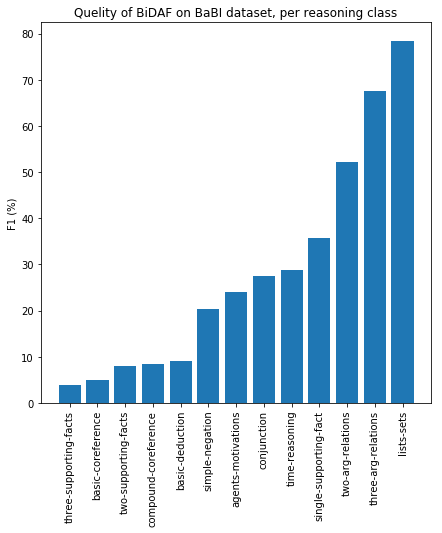

In [23]:
from evaluate11 import metric_max_over_ground_truths, f1_score, exact_match_score

# find the quality per reasoning type
scores = []
unique_types111 = set(bibi_reasoning_types)
for c in unique_types111:
    predictions_a = np.array([pred_ans_ad[i] for i, r in enumerate(bibi_reasoning_types) if r == c])
    labels_a = np.array([labels_ad[i] for i, r in enumerate(bibi_reasoning_types) if r == c])
    similarity = [f1_score(x,y) for x,y in zip(predictions_a, labels_a)]
    assert len(predictions_a) == len(labels_a)
    print(str(c) + " -> " + str(100.0 * sum(similarity) / len(predictions_a)))
    scores.append(100.0 * sum(similarity) / len(predictions_a))

similarity = [f1_score(x,y) for x,y in zip(pred_ans, labels)]


import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['axes.unicode_minus'] = False
fig, ax = plt.subplots(figsize=(7, 7))

scores_zipped_labels = list(zip(scores,unique_types111))
scores_zipped_labels.sort(key=lambda x: x[0])
scores22, unique_types22 = zip(*scores_zipped_labels)

plt.bar(range(len(scores22)), scores22)
# ax.plot(range(len(scores)), scores, 'o')
ax.set_ylabel('F1 (%)')
ax.set_title('Quelity of BiDAF on BaBI dataset, per reasoning class')
# ax.set_yticks(range(len(q_labels)))
# ax.set_xticks(range(len(bibi_reasoning_types)))
ax.set_xticks(np.arange(len(unique_types22)))

# ax.set_yticklabels(q_labels)
ax.set_xticklabels(unique_types22, rotation=90)
plt.show()

In [26]:
mat_concat = np.concatenate((mat, mat_ad), axis=0)
reasoning_types = ["squad"]*len(pred_ans) + bibi_reasoning_types
unique_reasoning_types = list(set(bibi_reasoning_types))
# unique_reasoning_types_indices = list(range(len(unique_reasoning_types)))
bibi_reasoning_type_indices = [unique_reasoning_types.index(x) for x in bibi_reasoning_types]
labels_concat = np.concatenate((labels, labels_ad))
pred_concat = np.concatenate((pred_ans, pred_ans_ad))

In [27]:
from sklearn.cluster import KMeans
db = KMeans(n_clusters=len(unique_reasoning_types), random_state=2).fit(mat_ad)
# db = DBSCAN(eps=0.3, min_samples=10).fit(mat_ad)
# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True
labelsss = db.labels_

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import cluster, metrics

matt1 = confusion_matrix(bibi_reasoning_type_indices, labelsss)
max_values = np.max(matt1, axis=1)
max_indices = np.argmax(matt1, axis=1)
    

max_indices = list(enumerate(max_indices))
max_indices.sort(key=lambda x: x[1])
new_ordering = [x[0] for x in max_indices]

matt = matt1[new_ordering, :]

matt1, max_values, max_indices, new_ordering, matt1[new_ordering, :]

(array([[  0,   0,   0,   0,   0, 186,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0, 115,   3,   0,   0,   0,   0,   0, 169,   1,   1],
        [  0,   0,   0,  10,   0,   0,   8,   7,   2,   0,  94,   0,   9],
        [713,   0,   0,   0,   0,   0,   0,   0,   0, 286,   0,   0,   0],
        [  0,   0,   0,   0,  95,   0, 135,   1, 323,   0,  50,   0,   0],
        [  0,   0, 176,  15,   0,   0,   0, 245,   0,   0,   0,   0, 164],
        [  0,   0, 119,  87,   0,   0,   0, 260,   0,   0,   0,   0, 134],
        [  0,   0,  71, 118, 301,   0,   0,   0,   0,   0,   0, 243,  19],
        [  0, 321,   0,   2,  11,   0,   0,   0,   0,   0,   0,   1,  89],
        [  0,   0, 105,  54,   0,   0,   0, 311,   0,   0,   0,   0, 130],
        [  0,   0, 162,  20,   0,   0,   0, 265,   0,   0,   0,   0, 153],
        [  0,   0,  32, 189,  76,   0,   0,   0,   0,   0,   0,  66,  25],
        [  0,   0,   0,   1,   0,   0, 232,   0,   0,   0,  99,   0,   0]]),
 array([186, 169,  94, 

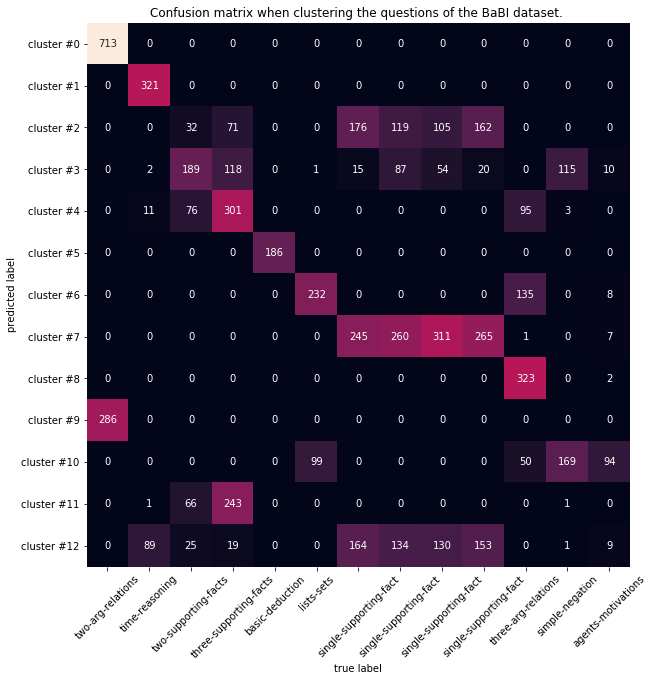

13
ars: 0.36046123193936175


In [29]:
plt.figure(figsize=(10, 10))
sss = sns.heatmap(matt.T, square=True,
            annot=True,
            fmt='d', cbar=False,
            xticklabels=True,
            yticklabels=True
            )

values, counts = np.unique(bibi_reasoning_types, return_counts=True)

count_per_label = dict(zip(counts, values))

new_label_ordering = [count_per_label[c] for c in np.sum(matt, axis=1)]

y_labels = ['cluster #' + str(i) for i in range(len(unique_reasoning_types))]
sss.set_xticklabels(new_label_ordering, rotation=45)
sss.set_yticklabels(y_labels, rotation=0)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Confusion matrix when clustering the questions of the BaBI dataset. ')
plt.show()
print(len(unique_reasoning_types))

ars = metrics.adjusted_rand_score(labelsss, bibi_reasoning_type_indices)
print("ars: " + str(ars))

In [64]:
# couts of the types  
values, counts = np.unique(bibi_reasoning_types, return_counts=True)

count_per_label = dict(zip(counts, values))

new_label_ordering = [count_per_label[c] for c in np.sum(matt, axis=1)]

values, counts,dict(zip(counts, values)), new_label_ordering

(array(['agents-motivations', 'basic-coreference', 'basic-deduction',
        'compound-coreference', 'conjunction', 'lists-sets',
        'simple-negation', 'single-supporting-fact', 'three-arg-relations',
        'three-supporting-facts', 'time-reasoning', 'two-arg-relations',
        'two-supporting-facts'], dtype='<U22'),
 array([130, 600, 186, 600, 600, 332, 289, 600, 604, 752, 424, 999, 388]),
 {130: 'agents-motivations',
  600: 'single-supporting-fact',
  186: 'basic-deduction',
  332: 'lists-sets',
  289: 'simple-negation',
  604: 'three-arg-relations',
  752: 'three-supporting-facts',
  424: 'time-reasoning',
  999: 'two-arg-relations',
  388: 'two-supporting-facts'},
 ['two-arg-relations',
  'time-reasoning',
  'two-supporting-facts',
  'three-supporting-facts',
  'basic-deduction',
  'lists-sets',
  'single-supporting-fact',
  'single-supporting-fact',
  'single-supporting-fact',
  'single-supporting-fact',
  'three-arg-relations',
  'agents-motivations',
  'simple-negation'

lists-sets -> 78.49535988565779
simple-negation -> 20.300111551383658
two-arg-relations -> 52.1950521950522
compound-coreference -> 8.451739352293382
agents-motivations -> 24.04645354645355
three-supporting-facts -> 3.8784005754064124
time-reasoning -> 28.775954581718683
basic-coreference -> 4.867682419284248
two-supporting-facts -> 7.996099424726351
conjunction -> 27.5323685213614
basic-deduction -> 9.035845915712434
single-supporting-fact -> 35.772348606559156
three-arg-relations -> 67.59088676155083


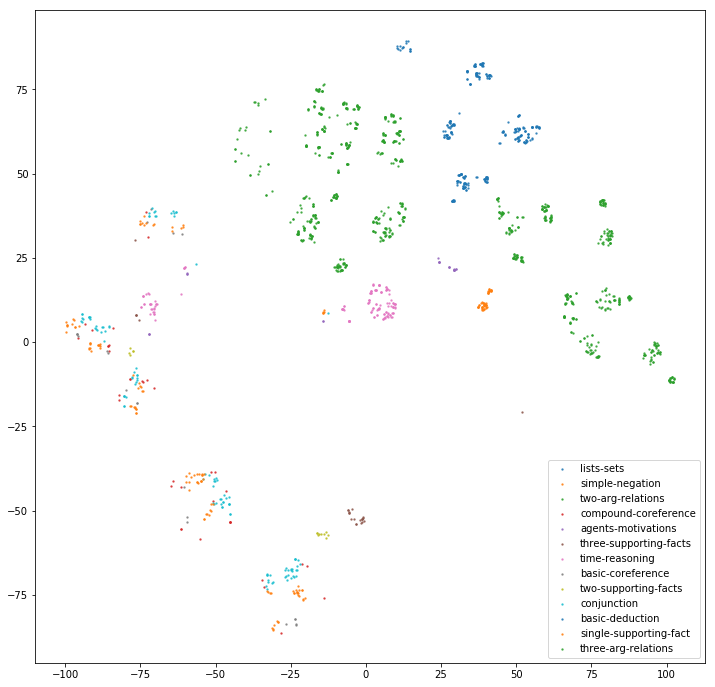

In [9]:
from evaluate11 import metric_max_over_ground_truths, f1_score, exact_match_score

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

(mat, labels, questions, pred_ans) = load_questions("ipython/babi/out3.txt", "ipython/babi/out22.txt", max_size=100)
(mat_ad, labels_ad, questions_ad, pred_ans_ad) = load_questions("ipython/babi/out33-adv.txt", "ipython/babi/out22-adv.txt", max_size=-1)

# read the questions and remember question ids:
question_paragraph_id_map = {}
ff = "/Users/daniel/ideaProjects/allennlp/QA_datasets/babi-test.json"
with open(ff) as file:
    dataset_json = json.load(file)
    dataset = dataset_json['data']
    for article in dataset:
        for paragraph in article['paragraphs']:
            for qa in paragraph['qas']:
                key = qa['question'] + paragraph['context']
                id = qa['id']
                question_paragraph_id_map[key] = id

bibi_reasoning_types = [question_paragraph_id_map[x["q"]+x["p"]] for x in questions_ad]

# find the quality per reasoning type
for c in set(bibi_reasoning_types):
    predictions_a = np.array([pred_ans_ad[i] for i, r in enumerate(bibi_reasoning_types) if r == c])
    labels_a = np.array([labels_ad[i] for i, r in enumerate(bibi_reasoning_types) if r == c])
    similarity = [f1_score(x,y) for x,y in zip(predictions_a, labels_a)]
    assert len(predictions_a) == len(labels_a)
    print(str(c) + " -> " + str(100.0 * sum(similarity) / len(predictions_a)))

similarity = [f1_score(x,y) for x,y in zip(pred_ans, labels)]
# print("Squad -> ", str(100.0 * sum(similarity) / len(pred_ans)))


mat_concat = np.concatenate((mat, mat_ad), axis=0)
reasoning_types = ["squad"]*len(pred_ans) + bibi_reasoning_types
unique_reasoning_types = list(set(bibi_reasoning_types))
# unique_reasoning_types_indices = list(range(len(unique_reasoning_types)))
bibi_reasoning_type_indices = [unique_reasoning_types.index(x) for x in bibi_reasoning_types]
labels_concat = np.concatenate((labels, labels_ad))
pred_concat = np.concatenate((pred_ans, pred_ans_ad))

X_embedded = TSNE(n_components=2,init="pca").fit_transform(mat_concat)
fig, ax = plt.subplots(figsize=(12, 12))
for iter, c in enumerate(unique_reasoning_types):
    X_selected = np.asarray([X_embedded[i, :] for i, r in enumerate(reasoning_types) if r == c and f1_score(pred_concat[i], labels_concat[i]) > 0.6])
    plt.scatter(X_selected[:, 0], X_selected[:, 1], alpha=0.7, s=2, label=c) # color=color_map[iter],

ax.legend()
plt.show()